<a href="https://colab.research.google.com/github/aulia-adil/craiglist-sales/blob/adil/Proyek_Akhir_KASDD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Module dan Dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [ ]:
def download_from_gdrive(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.FetchMetadata(fetch_all=True)
  downloaded.GetContentFile(downloaded.metadata['title'])

In [ ]:
# import cell
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# Colab harus menggunakan akun UI untuk bisa mendownload file ini
download_from_gdrive('1BpEsEOQyd9F7m4TC7oGfu6e0wKtHV7gj')

In [ ]:
!unzip 'archive.zip'

Archive:  archive.zip
  inflating: vehicles.csv            


In [ ]:
data = pd.read_csv("vehicles.csv")
print("Dimensi:", data.shape)
data.tail()

Dimensi: (426880, 26)


,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
426875,7301591192,https://wyoming.craigslist.org/ctd/d/atlanta-2...,wyoming,https://wyoming.craigslist.org,23590,2019.0,nissan,maxima s sedan 4d,good,6 cylinders,gas,32226.0,clean,other,1N4AA6AV6KC367801,fwd,NaN,sedan,NaN,https://images.craigslist.org/00o0o_iiraFnHg8q...,Carvana is the safer way to buy a car During t...,NaN,wy,33.786500,-84.445400,2021-04-04T03:21:31-0600
426876,7301591187,https://wyoming.craigslist.org/ctd/d/atlanta-2...,wyoming,https://wyoming.craigslist.org,30590,2020.0,volvo,s60 t5 momentum sedan 4d,good,NaN,gas,12029.0,clean,other,7JR102FKXLG042696,fwd,NaN,sedan,red,https://images.craigslist.org/00x0x_15sbgnxCIS...,Carvana is the safer way to buy a car During t...,NaN,wy,33.786500,-84.445400,2021-04-04T03:21:29-0600
426877,7301591147,https://wyoming.craigslist.org/ctd/d/atlanta-2...,wyoming,https://wyoming.craigslist.org,34990,2020.0,cadillac,xt4 sport suv 4d,good,NaN,diesel,4174.0,clean,other,1GYFZFR46LF088296,NaN,NaN,hatchback,white,https://images.craigslist.org/00L0L_farM7bxnxR...,Carvana is the safer way to buy a car During t...,NaN,wy,33.779214,-84.411811,2021-04-04T03:21:17-0600
426878,7301591140,https://wyoming.craigslist.org/ctd/d/atlanta-2...,wyoming,https://wyoming.craigslist.org,28990,2018.0,lexus,es 350 sedan 4d,good,6 cylinders,gas,30112.0,clean,other,58ABK1GG4JU103853,fwd,NaN,sedan,silver,https://images.craigslist.org/00z0z_bKnIVGLkDT...,Carvana is the safer way to buy a car During t...,NaN,wy,33.786500,-84.445400,2021-04-04T03:21:11-0600
426879,7301591129,https://wyoming.craigslist.org/ctd/d/atlanta-2...,wyoming,https://wyoming.craigslist.org,30590,2019.0,bmw,4 series 430i gran coupe,good,NaN,gas,22716.0,clean,other,WBA4J1C58KBM14708,rwd,NaN,coupe,NaN,https://images.craigslist.org/00Y0Y_lEUocjyRxa...,Carvana is the safer way to buy a car During t...,NaN,wy,33.779214,-84.411811,2021-04-04T03:21:07-0600


## Exploratory Data Analysis dan Preprocessing

county          426880
size            306361
cylinders       177678
condition       174104
VIN             161042
drive           130567
paint_color     130203
type             92858
manufacturer     17646
title_status      8242
long              6549
lat               6549
model             5277
odometer          4400
fuel              3013
transmission      2556
year              1205
description         70
posting_date        68
image_url           68
state                0
price                0
region_url           0
region               0
url                  0
id                   0
dtype: int64

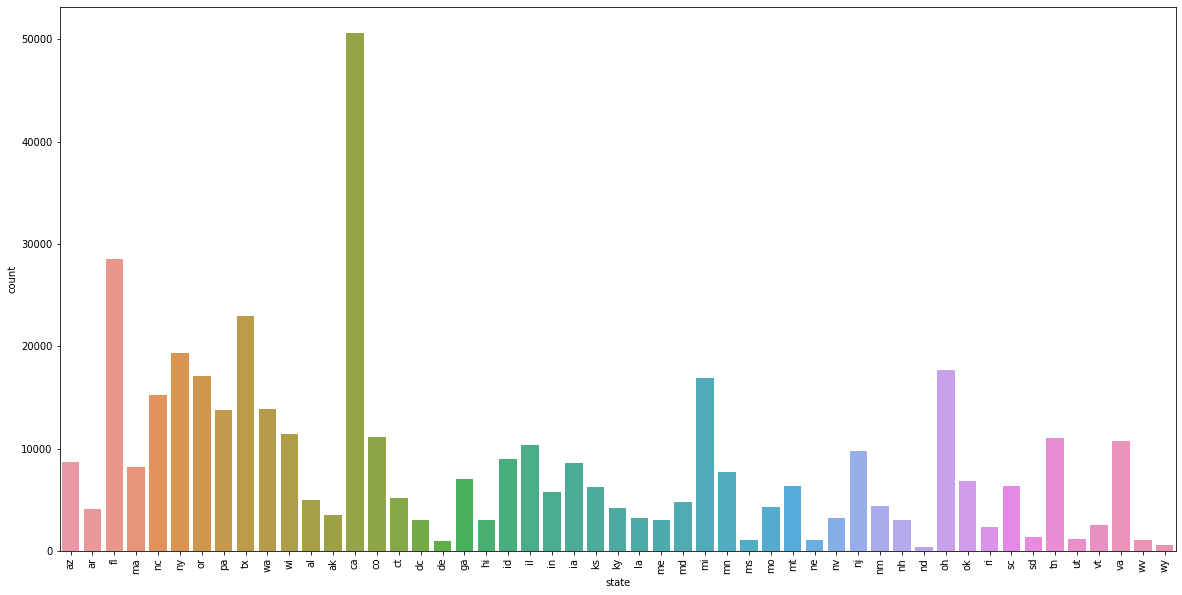

State yang paling banyak memposting iklan adalah CA


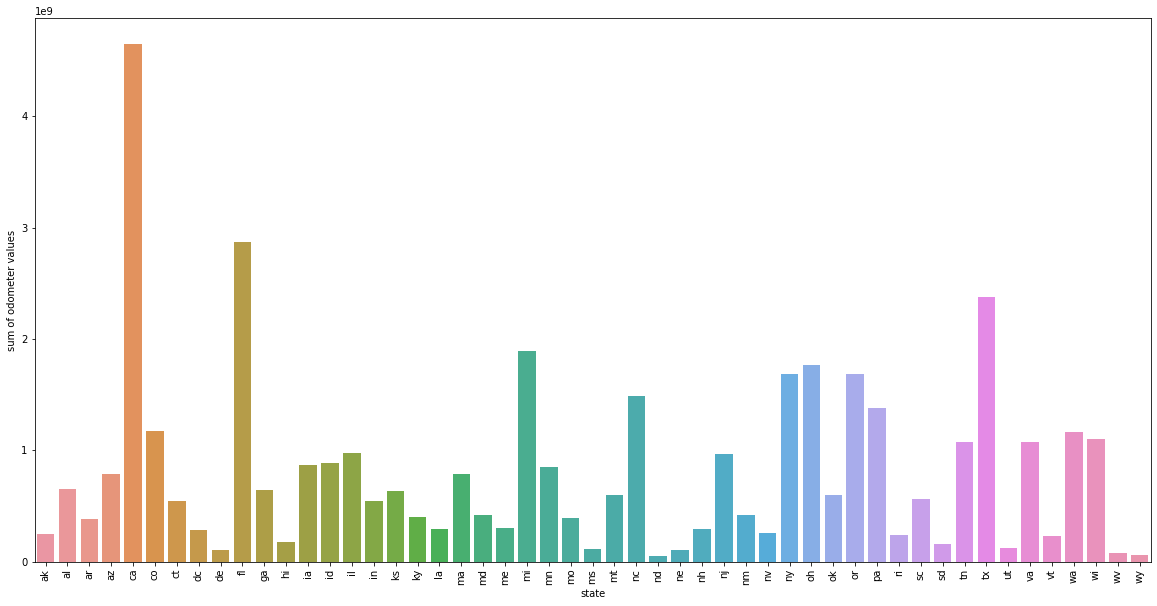

State yang paling sering menggunakan mobil adalah CA


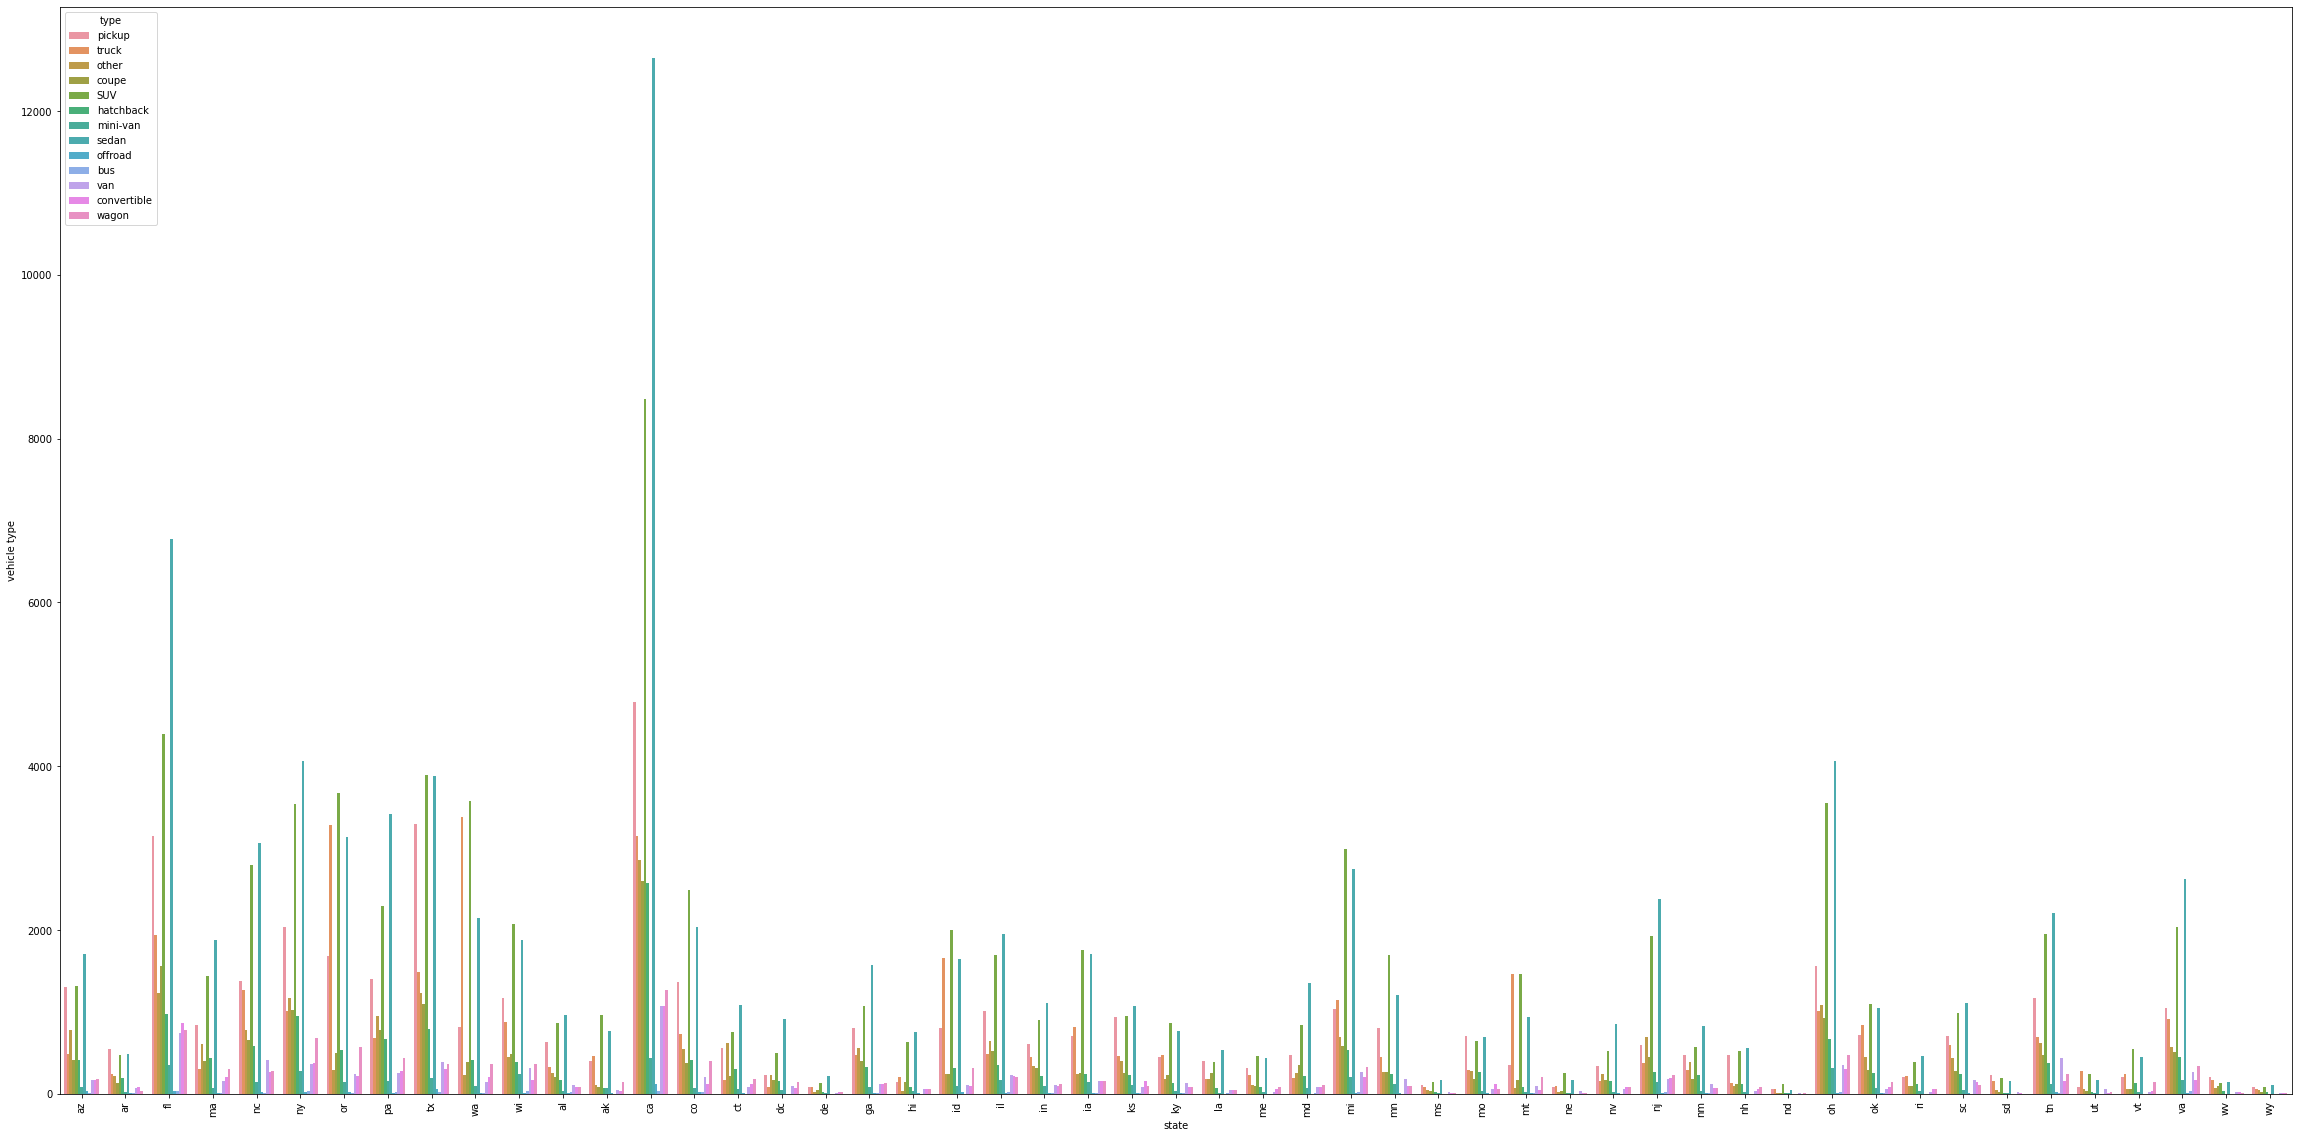

In [ ]:
# Menampilkan missing values secara descending
display(data.isna().sum().sort_values(ascending = False))

cleaned_data = data.copy()
# Drop kolom county
cleaned_data.drop(columns = ['county'], inplace = True)

# Visualisasi banyak iklan yang diposting setiap state
plt.figure(figsize = (20, 10))
sns.countplot(x = 'state', data = data)
plt.xlabel("state")
plt.xticks(rotation = "vertical")
plt.show()
print("State yang paling banyak memposting iklan adalah CA")

# Visualisasi jumlah nilai odometer untuk setiap state
# (Hint di soal disuruh pake year sama odometer, tapi menurutku odometer cukup)
state_odo = cleaned_data.loc[:, ['state', 'odometer']]
state_odo = state_odo.groupby('state', as_index = False).sum()

plt.figure(figsize = (20, 10))
sns.barplot(x = 'state', y = 'odometer', data = state_odo)
plt.xlabel("state")
plt.ylabel("sum of odometer values")
plt.xticks(rotation = "vertical")
plt.show()
print("State yang paling sering menggunakan mobil adalah CA")

#
state_type = cleaned_data.loc[:, ['state', 'type']]
plt.figure(figsize = (40, 20))
sns.countplot(x = 'state', hue = 'type', data = state_type)
plt.xlabel("state")
plt.ylabel("vehicle type")
plt.xticks(rotation = "vertical")
plt.show()